In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import copy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
sklearn.utils.check_random_state(SEED)

RandomState(MT19937) at 0x7B34BC201840

# Neural Networks for Classification

In this notebook, we'll explore neural networks for classification tasks. Specifically, we'll implement Multi-Layer Perceptrons (MLPs) in PyTorch for classification tasks of increasing complexity. We'll start with some simple synthetic data, and then we'll graduate to some more complex real-world data.

Let's start with our first dataset, where our task is to classify points into two concentric circles:

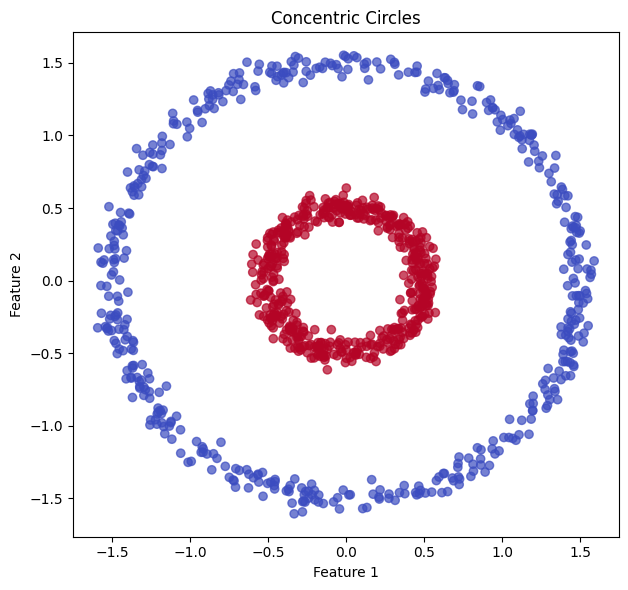

In [3]:
def generate_circles_data(n_samples=1000, noise=0.1, random_state=None):
    """
    Generate a dataset with concentric circles.

    Args:
        n_samples: Number of data points
        noise: Amount of noise to add
        random_state: Random seed

    Returns:
        X: Features of shape (n_samples, 2)
        y: Labels of shape (n_samples,)
    """
    if random_state is not None:
        np.random.seed(random_state)

    # Inner circle (class 1)
    inner_samples = n_samples // 2
    inner_r = 0.5
    inner_theta = np.random.uniform(0, 2*np.pi, inner_samples)
    inner_x = inner_r * np.cos(inner_theta) + noise * np.random.randn(inner_samples)
    inner_y = inner_r * np.sin(inner_theta) + noise * np.random.randn(inner_samples)
    inner_points = np.column_stack([inner_x, inner_y])
    inner_labels = np.ones(inner_samples)

    # Outer circle (class 0)
    outer_samples = n_samples - inner_samples
    outer_r = 1.5
    outer_theta = np.random.uniform(0, 2*np.pi, outer_samples)
    outer_x = outer_r * np.cos(outer_theta) + noise * np.random.randn(outer_samples)
    outer_y = outer_r * np.sin(outer_theta) + noise * np.random.randn(outer_samples)
    outer_points = np.column_stack([outer_x, outer_y])
    outer_labels = np.zeros(outer_samples)

    # Combine data
    X = np.vstack([inner_points, outer_points])
    y = np.hstack([inner_labels, outer_labels])

    # Shuffle the data
    idx = np.random.permutation(n_samples)
    X = X[idx]
    y = y[idx]

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

def generate_cool_data(n_points=100, noise=0.05, random_state=None, background_points=1000, d=0.1):
    """
    Generates data with points on a "cool S" shape as class 1 and random background points as class 0.
    Points within distance d of any shape segment are also labeled as class 1.

    Args:
        n_points: Number of points per segment on the shape
        noise: Amount of noise to add to the shape points
        random_state: Random seed for reproducibility
        background_points: Number of random background points (class 0)
        d: Distance threshold - background points within this distance of a shape segment become class 1

    Returns:
        X: Tensor of shape (n_total_points, 2) containing the coordinates
        y: Tensor of shape (n_total_points,) containing the class labels (0 or 1)
    """
    if random_state is not None:
        np.random.seed(random_state)

    # Define the key points of the cool S
    # These coordinates define the shape in segments
    shape_segments = [
        [(1,1),(1,1.75)],
        [(2,-0.75),(2,0)],
        [(0,-0.75),(0,0)],
        [(2,0),(1,1)],
        [(0,0),(0.25,0.25)],
        [(2,-0.75),(1,-1.75)],
        [(1,-1.75),(0,-0.75)],
        [(2,1),(2,1.75)],
        [(1.75,0.75),(2,1)],
        [(2,1.75),(1,2.75)],
        [(1,2.75),(0,1.75)],
        [(0,1),(0,1.75)],
        [(1,0),(0,1)],
        [(1,-0.75),(1,0)],
    ]

    # Generate points along each segment (all will be class 1)
    shape_x = []
    shape_y = []

    for segment in shape_segments:
        for i in range(len(segment) - 1):
            # Starting and ending points of this line segment
            x0, y0 = segment[i]
            x1, y1 = segment[i + 1]

            # Generate points along the line
            t = np.linspace(0, 1, n_points)
            x = x0 + t * (x1 - x0)
            y = y0 + t * (y1 - y0)

            # Add some random noise
            x += np.random.normal(0, noise, n_points)
            y += np.random.normal(0, noise, n_points)

            shape_x.extend(x)
            shape_y.extend(y)

    # Generate random background points (class 0)
    # Define the bounds of the plot
    x_min, x_max = -0.5, 2.5
    y_min, y_max = -2.0, 3.0

    background_x = np.random.uniform(x_min, x_max, background_points)
    background_y = np.random.uniform(y_min, y_max, background_points)

    # Create shape points array
    shape_points = np.column_stack([shape_x, shape_y])

    # Create background points array
    background_points_array = np.column_stack([background_x, background_y])

    # Initialize background labels as all zeros
    background_labels = np.zeros(len(background_x))

    # For each background point, check if it's within distance d of any shape point
    for i in range(len(background_x)):
        bg_point = background_points_array[i]

        # Calculate distances to all shape points
        distances = np.sqrt(np.sum((shape_points - bg_point)**2, axis=1))

        # If any distance is less than d, mark this background point as class 1
        if np.any(distances < d):
            background_labels[i] = 1

    # Combine shape points (class 1) and background points (with mixed labels)
    x_points = np.concatenate([background_x, shape_x])
    y_points = np.concatenate([background_y, shape_y])

    # Create labels: background_labels for background, 1 for shape points
    labels = np.concatenate([background_labels, np.ones(len(shape_x))])

    # Combine into feature matrix and labels
    X = np.column_stack([x_points, y_points])
    y = np.array(labels)

    # Shuffle the data
    indices = np.random.permutation(len(y))
    X = X[indices]
    y = y[indices]

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    """
    Plots the decision boundary of a model.

    Args:
        model: Trained PyTorch model
        X: Input features
        y: True labels
        title: Plot title
    """
    # Set min and max values
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Create a meshgrid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Convert to torch tensors
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # Make predictions
    with torch.no_grad():
        Z = model(grid)
        if isinstance(Z, tuple):
            Z = Z[0]  # Some models return (outputs, hidden_states)
        if Z.shape[1] > 1:  # If model outputs logits for multiple classes
            Z = torch.argmax(Z, dim=1)
        else:  # If model outputs a single value
            Z = (Z > 0.5).long().squeeze()

    # Reshape back to meshgrid shape
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']),
                edgecolors='k', s=40)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Let's visualize our datasets
plt.figure(figsize=(12, 6))

# Concentric circles data
X, y = generate_circles_data(n_samples=1000, noise=0.05, random_state=SEED)
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title('Concentric Circles')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

## I. Baseline: a linear classifier

What kind of model would be able to learn the circular decision boundary needed for this classification task?

Well, let's see if the models we've learned about so far can do the job. Below we've implemented a simple linear classifier that takes in two features and outputs a single value using a sigmoid activation function, which ensures that the output is a probability between 0 and 1. The model is trained using binary cross-entropy loss and the Adam optimizer.

In [4]:
class LinearClassifier(nn.Module):
    """
    A simple linear classifier with no hidden layers.
    """

    def __init__(self, input_dim, output_dim=1):
        """
        Initialize the linear classifier.

        Args:
            input_dim: Number of input features
            output_dim: Number of output units (1 for binary classification)
        """
        super(LinearClassifier, self).__init__()

        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (batch_size, input_dim)

        Returns:
            Output tensor of shape (batch_size, output_dim)
        """
        return self.sigmoid(self.linear(x))

In [5]:
def train_model(model, X, y, n_epochs=1000, learning_rate=0.01, verbose=True):
    """
    Train a classification model (works for both linear classifiers and MLPs).

    Args:
        model: PyTorch model
        X: Input features
        y: Target labels
        n_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        verbose: Whether to print progress

    Returns:
        Trained model and training losses
    """
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=SEED
    )

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    losses = []
    val_losses = []
    val_accuracies = []

    # Evaluate model at epoch 0 (before training)
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val.float().unsqueeze(1)).item()
        val_losses.append(val_loss)

        # Calculate accuracy
        val_preds = (val_outputs > 0.5).long().squeeze()
        val_acc = (val_preds == y_val).float().mean().item()
        val_accuracies.append(val_acc)

    # Log initial performance
    if verbose:
        print(f"Epoch 0 (Before training), "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}")

    # Initial training loss
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.float().unsqueeze(1))
    losses.append(loss.item())

    for epoch in range(n_epochs):
        model.train()

        # Forward pass on entire training set
        outputs = model(X_train)

        # Calculate loss
        loss = criterion(outputs, y_train.float().unsqueeze(1))

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Calculate gradients
        optimizer.step()       # Update weights

        # Record training loss
        losses.append(loss.item())

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val.float().unsqueeze(1)).item()
            val_losses.append(val_loss)

            # Calculate accuracy
            val_preds = (val_outputs > 0.5).long().squeeze()
            val_acc = (val_preds == y_val).float().mean().item()
            val_accuracies.append(val_acc)

        if verbose and (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, "
                  f"Train Loss: {loss.item():.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")

    print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.025)

    plt.tight_layout()
    plt.show()

    return model, losses

Epoch 0 (Before training), Val Loss: 0.7129, Val Acc: 0.5600
Epoch 100/300, Train Loss: 0.6911, Val Loss: 0.7020, Val Acc: 0.5600
Epoch 200/300, Train Loss: 0.6910, Val Loss: 0.7044, Val Acc: 0.6150
Epoch 300/300, Train Loss: 0.6910, Val Loss: 0.7044, Val Acc: 0.6150
Final validation accuracy: 0.6150


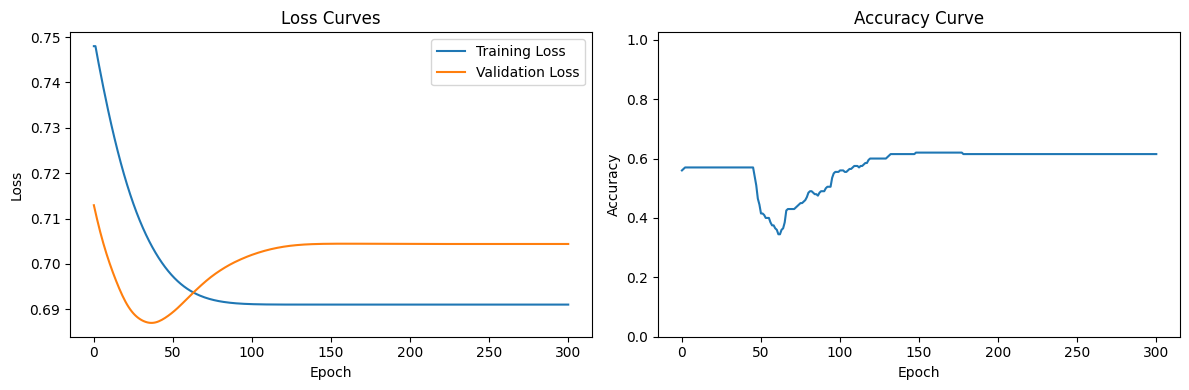

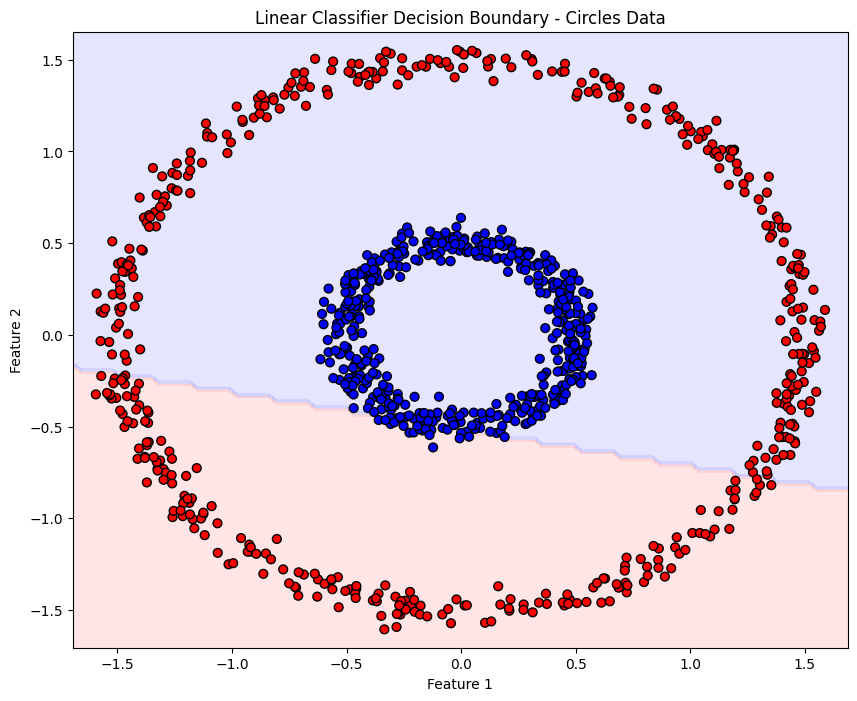

In [6]:
# Generate concentric circles data
X_circles, y_circles = generate_circles_data(n_samples=1000, noise=0.05, random_state=SEED)

# Define and train the linear classifier
input_dim = 2  # We have 2D input features
output_dim = 1  # Binary classification (0 or 1)

model_linear = LinearClassifier(input_dim, output_dim)
model_linear, _ = train_model(model_linear, X_circles, y_circles, n_epochs=300)

# Visualize the decision boundary
plot_decision_boundary(model_linear, X_circles, y_circles, 'Linear Classifier Decision Boundary - Circles Data')

As we can see, the linear classifier fails to learn the circular decision boundary. Because it is a linear model, it can only learn a straight line that separates the data, which is insufficient for this problem. You can also see this in the model's loss and accuracy curves, which plateau at a high values.

So what can we do to solve this problem?

## II. Adding Non-Linearity

To solve the concentric circles problem, we need to introduce non-linearities into our model. This is where activation functions come in!

Let's visualize and understand some common activation functions:

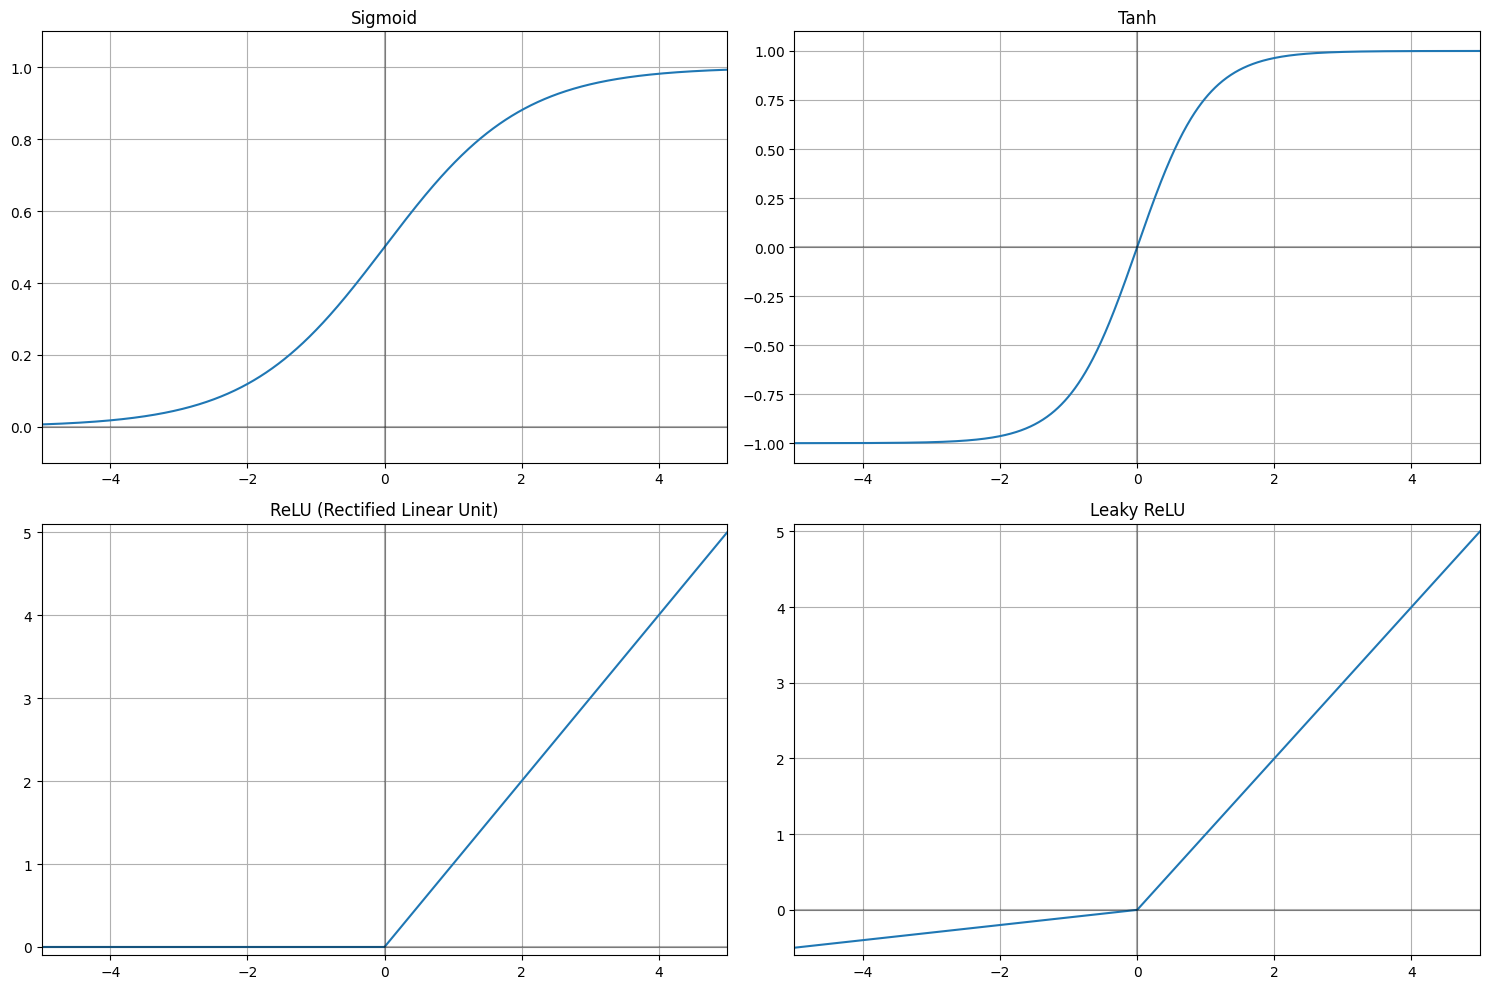

In [7]:
def plot_activation_functions():
    """
    Visualizes common activation functions used in neural networks.
    """
    # Create input values
    x = np.linspace(-5, 5, 1000)

    # Calculate outputs for different activation functions
    sigmoid = 1 / (1 + np.exp(-x))
    tanh = np.tanh(x)
    relu = np.maximum(0, x)
    leaky_relu = np.where(x > 0, x, 0.1 * x)

    # Plot the activation functions
    plt.figure(figsize=(15, 10))

    # Sigmoid
    plt.subplot(2, 2, 1)
    plt.plot(x, sigmoid)
    plt.title('Sigmoid')
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.xlim(-5, 5)
    plt.ylim(-0.1, 1.1)

    # Tanh
    plt.subplot(2, 2, 2)
    plt.plot(x, tanh)
    plt.title('Tanh')
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.xlim(-5, 5)
    plt.ylim(-1.1, 1.1)

    # ReLU
    plt.subplot(2, 2, 3)
    plt.plot(x, relu)
    plt.title('ReLU (Rectified Linear Unit)')
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.xlim(-5, 5)
    plt.ylim(-0.1, 5.1)

    # Leaky ReLU
    plt.subplot(2, 2, 4)
    plt.plot(x, leaky_relu)
    plt.title('Leaky ReLU')
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.xlim(-5, 5)
    plt.ylim(-0.6, 5.1)

    plt.tight_layout()
    plt.show()

# Visualize the activation functions
plot_activation_functions()

# Activation Functions in Neural Networks

Activation functions introduce non-linearity into our models, allowing them to learn more complex non-linear patterns. We've plotted four of the most common activation functions above:

#### Sigmoid
- Maps input to a value between 0 and 1
- Historically popular but suffers from vanishing gradient problem*
- Useful for binary classification output layers
- Formula: σ(x) = 1/(1 + e^(-x))

#### Tanh (Hyperbolic Tangent)
- Maps input to a value between -1 and 1
- Zero-centered, which helps with optimization
- Still has vanishing gradient issues at extremes*
- Formula: tanh(x) = (e^x - e^(-x))/(e^x + e^(-x))

#### ReLU (Rectified Linear Unit)
- Returns x if x > 0, otherwise returns 0
- Computationally efficient and helps solve vanishing gradient problem
- Can cause "dying ReLU" problem where neurons stop learning
- Formula: ReLU(x) = max(0, x)

#### Leaky ReLU
- Modification of ReLU that allows small negative values
- Prevents dying ReLU problem by allowing gradient flow for negative inputs
- Formula: Leaky_ReLU(x) = max(αx, x) where α is a small constant (typically 0.01)

We can use these activation functions to build non-linear models by stacking linear projections with non-linear activation functions on top of one another. In fact, this is exactly what a multi-layer perceptron is -- one of the simplest types of neural networks!

*Note: What's the vanishing gradient problem? This is a problem where the gradient of the loss function becomes very small, which makes it difficult to train the model because the updates to the weights are too small to make a difference. This becomes an especially big problem when we start stacking many layers of linear transformations on top of one another, because the gradient of the loss function becomes very small as it passes through each layer. We won't go into the details in this notebook, but it's good to be aware of!


### Building a Simple MLP Classifier with Non-Linearity

Now, let's implement a simple MLP classifier by adding a hidden layer with a non-linear activation function. This should help us solve the concentric circles problem. In the code block below, you'll want to initialize a simple MLP with a linear layer that projects the input to a hidden dimension, a non-linear activation function (of your choice!) that introduces non-linearity, another linear layer that projects the hidden dimension to the output dimension, and a sigmoid activation function for the final output.

In [8]:
class SimpleMLPClassifier(nn.Module):
    """
    A simple MLP for binary classification.
    """

    def __init__(self, input_dim, hidden_dim, output_dim=1):
        """
        Initialize the MLP.

        Args:
            input_dim: Number of input features
            hidden_dim: Number of hidden units
            output_dim: Number of output units (1 for binary classification)
        """
        super(SimpleMLPClassifier, self).__init__()

        # ---- YOUR CODE HERE ----
        # Create the network layers:
        # 1. A linear layer from input_dim to hidden_dim
        # 2. A ReLU activation
        # 3. A linear layer from hidden_dim to output_dim
        # 4. A sigmoid activation for binary classification

        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        # ----------------------

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (batch_size, input_dim)

        Returns:
            Output tensor of shape (batch_size, output_dim)
        """
        # ---- YOUR CODE HERE ----
        return self.layers(x)
        # ----------------------

Epoch 0 (Before training), Val Loss: 0.6951, Val Acc: 0.5700
Epoch 100/300, Train Loss: 0.2639, Val Loss: 0.2878, Val Acc: 0.9150
Epoch 200/300, Train Loss: 0.0340, Val Loss: 0.0353, Val Acc: 1.0000
Epoch 300/300, Train Loss: 0.0113, Val Loss: 0.0120, Val Acc: 1.0000
Final validation accuracy: 1.0000


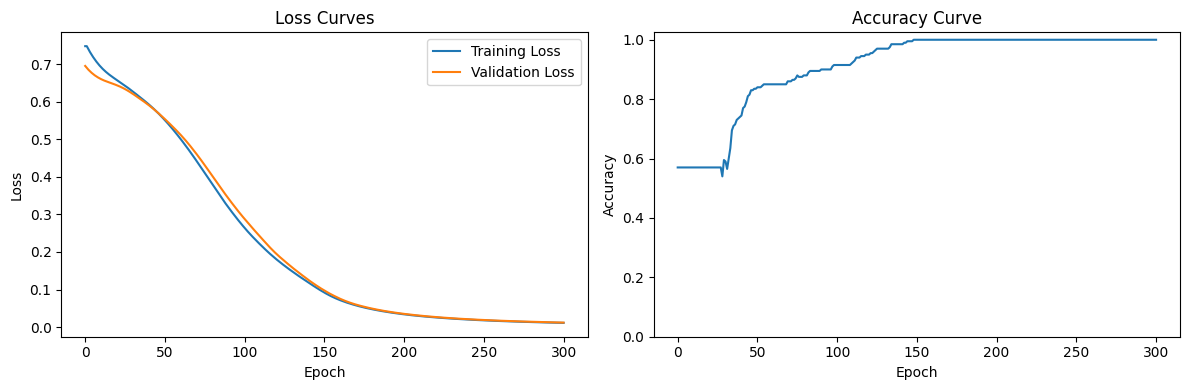

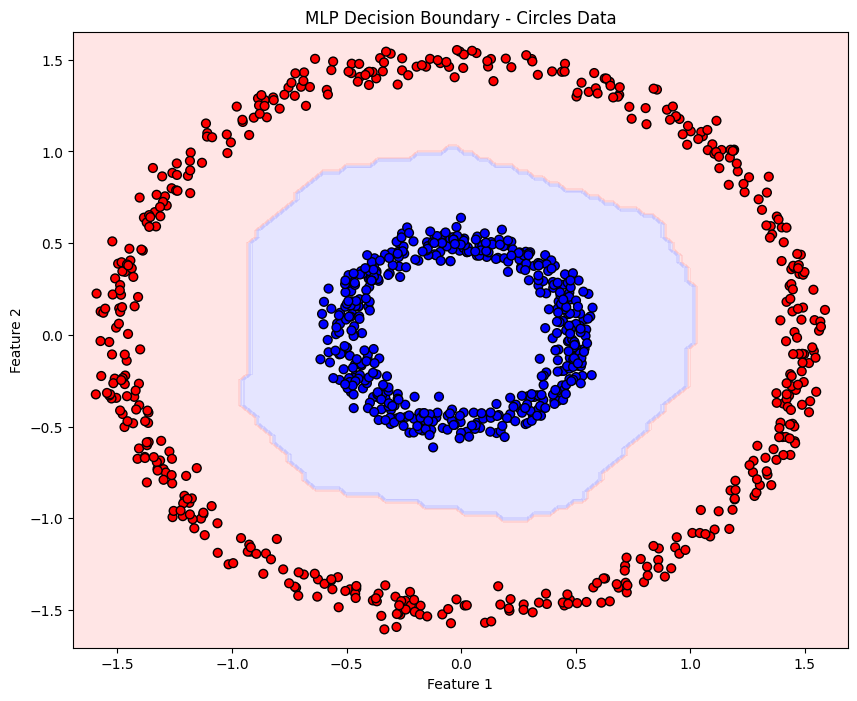

In [9]:
# Define and train the MLP for the concentric circles data
input_dim = 2  # We have 2D input features
hidden_dim = 10  # A small hidden layer should be sufficient for this task
output_dim = 1  # Binary classification (0 or 1)

model_circles_mlp = SimpleMLPClassifier(input_dim, hidden_dim, output_dim)
model_circles_mlp, _ = train_model(model_circles_mlp, X_circles, y_circles, n_epochs=300)

# Visualize the decision boundary
plot_decision_boundary(model_circles_mlp, X_circles, y_circles, 'MLP Decision Boundary - Circles Data')

Great! Our MLP with a hidden layer and non-linear activation function can successfully learn the circular decision boundary. Hopefully this gives you a sense of how introducing non-linearities can help a model learn more complex patterns than if it were purely linear.

## III. More Complex Problems: The "Cool S" Shape

Now, let's try a more challenging dataset: the "cool S" shape. This dataset requires an even more complex decision boundary.

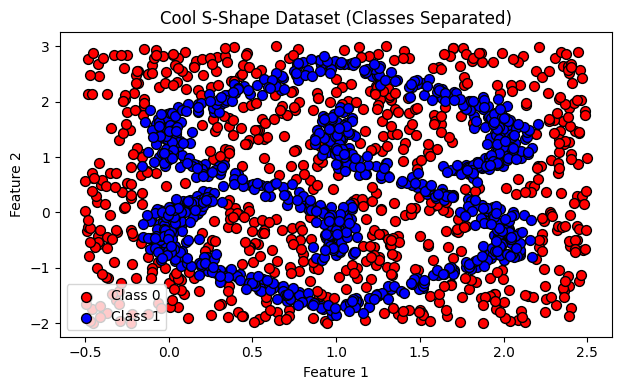

In [10]:
# Generate S-shape data
X_s, y_s = generate_cool_data(n_points=50, noise=0.05, random_state=SEED)

# Visualize the S-shape data
plt.figure(figsize=(12, 4))


# Plot the data with different colors for each class
plt.subplot(1, 2, 2)
plt.scatter(X_s[y_s == 0][:, 0], X_s[y_s == 0][:, 1], color='red', label='Class 0', edgecolors='k', s=50)
plt.scatter(X_s[y_s == 1][:, 0], X_s[y_s == 1][:, 1], color='blue', label='Class 1', edgecolors='k', s=50)
plt.title('Cool S-Shape Dataset (Classes Separated)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()

First let's see how our simple MLP performs on this dataset.

Epoch 0 (Before training), Val Loss: 0.7054, Val Acc: 0.3559
Epoch 100/1000, Train Loss: 0.6136, Val Loss: 0.6177, Val Acc: 0.6559
Epoch 200/1000, Train Loss: 0.5814, Val Loss: 0.5976, Val Acc: 0.6529
Epoch 300/1000, Train Loss: 0.5680, Val Loss: 0.5841, Val Acc: 0.6647
Epoch 400/1000, Train Loss: 0.5584, Val Loss: 0.5726, Val Acc: 0.6765
Epoch 500/1000, Train Loss: 0.5529, Val Loss: 0.5658, Val Acc: 0.6853
Epoch 600/1000, Train Loss: 0.5496, Val Loss: 0.5619, Val Acc: 0.6882
Epoch 700/1000, Train Loss: 0.5475, Val Loss: 0.5599, Val Acc: 0.6941
Epoch 800/1000, Train Loss: 0.5462, Val Loss: 0.5580, Val Acc: 0.7000
Epoch 900/1000, Train Loss: 0.5449, Val Loss: 0.5572, Val Acc: 0.6971
Epoch 1000/1000, Train Loss: 0.5422, Val Loss: 0.5557, Val Acc: 0.6971
Final validation accuracy: 0.6971


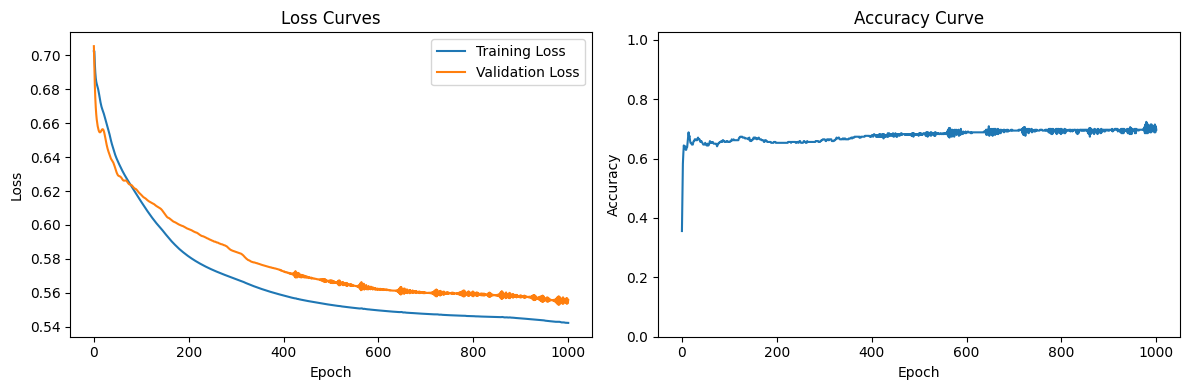

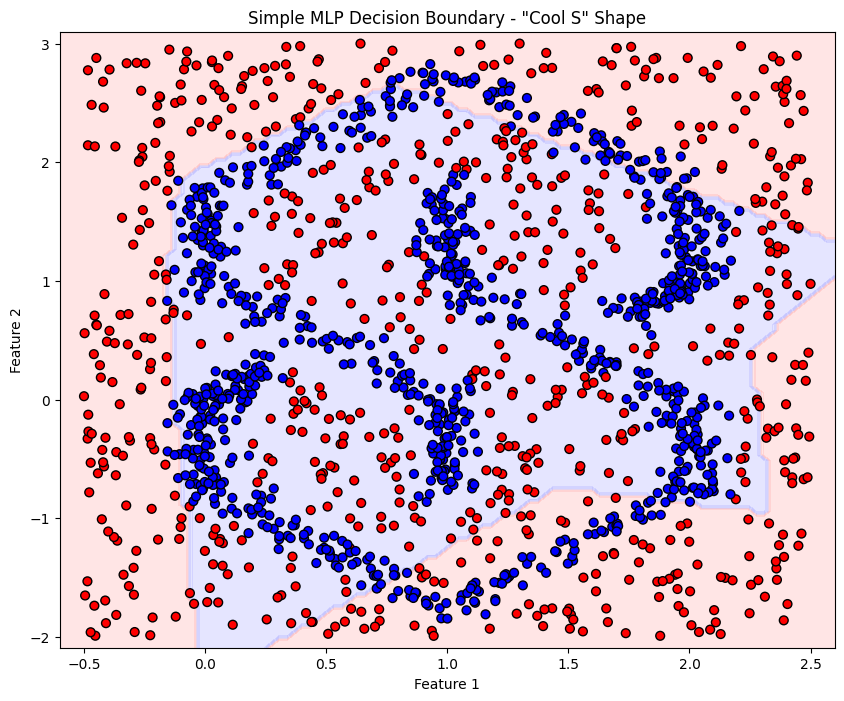

In [11]:
# Test our simple MLP on the Cool S data
model_s_simple = SimpleMLPClassifier(input_dim, hidden_dim, output_dim)
model_s_simple, _ = train_model(model_s_simple, X_s, y_s, n_epochs=1000)

# Visualize the decision boundary
plot_decision_boundary(model_s_simple, X_s, y_s, 'Simple MLP Decision Boundary - "Cool S" Shape')

As we can see, our simple MLP with a single hidden layer struggles with the complex "cool S" shape. Even though our network can learn the concentric circles problem, it doesn't have enough capacity to learn this much more complex decision boundary.

What can we do to solve this problem? It's actually quite simple -- we can add more layers to our network!

## IV. Deeper Networks for Complex Problems

To solve the cool S problem, we can use a deeper network with more hidden layers and units. Let's do that in the code block below. Your task is to upgrade the simple MLP class that you implemented earlier by building a new deep MLP class that can have any number of hidden layers and units. Note now that in this class the 'hidden_dim' argument has become a 'hidden_dims' argument, which is a list of hidden dimensions. For example, if hidden_dims = [64, 32, 16], this means that the network has 3 hidden layers that project into one another, with 64, 32, and 16 units respectively.

In [12]:
class DeepMLPClassifier(nn.Module):
    """
    A deeper MLP for complex classification tasks.
    """

    def __init__(self, input_dim, hidden_dims, output_dim=1):
        """
        Initialize the deep MLP.

        Args:
            input_dim: Number of input features
            hidden_dims: List of hidden dimensions
            output_dim: Number of output units (1 for binary classification)
        """
        super(DeepMLPClassifier, self).__init__()

        # ---- YOUR CODE HERE ----
        # Create a list of layers based on the provided hidden dimensions
        layers = []

        # Input layer to first hidden layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())

        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())

        # Create sequential model from layers
        self.network = nn.Sequential(*layers)
        # ----------------------

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (batch_size, input_dim)

        Returns:
            Output tensor of shape (batch_size, output_dim)
        """
        # ---- YOUR CODE HERE ----
        return self.network(x)
        # ----------------------

Epoch 0 (Before training), Val Loss: 0.6833, Val Acc: 0.6235
Epoch 100/500, Train Loss: 0.3624, Val Loss: 0.4144, Val Acc: 0.7971
Epoch 200/500, Train Loss: 0.2009, Val Loss: 0.2375, Val Acc: 0.9147
Epoch 300/500, Train Loss: 0.1094, Val Loss: 0.1521, Val Acc: 0.9559
Epoch 400/500, Train Loss: 0.0613, Val Loss: 0.1320, Val Acc: 0.9588
Epoch 500/500, Train Loss: 0.0938, Val Loss: 0.1772, Val Acc: 0.9353
Final validation accuracy: 0.9353


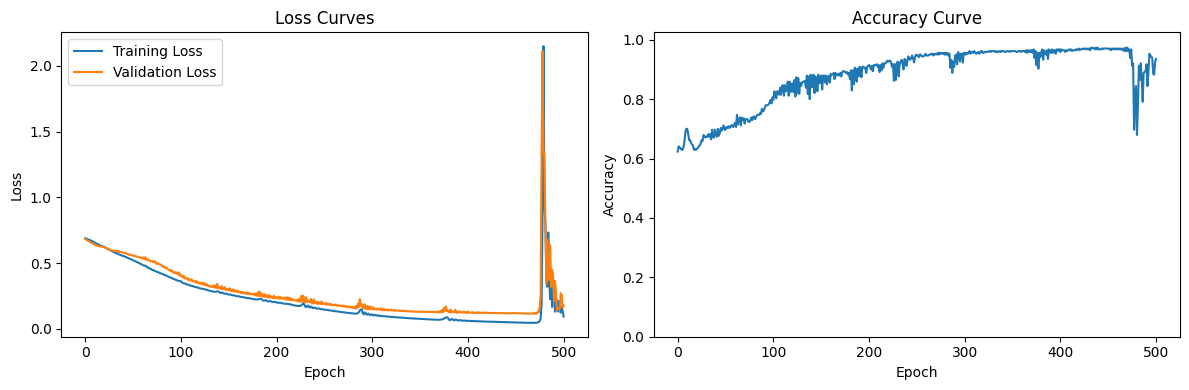

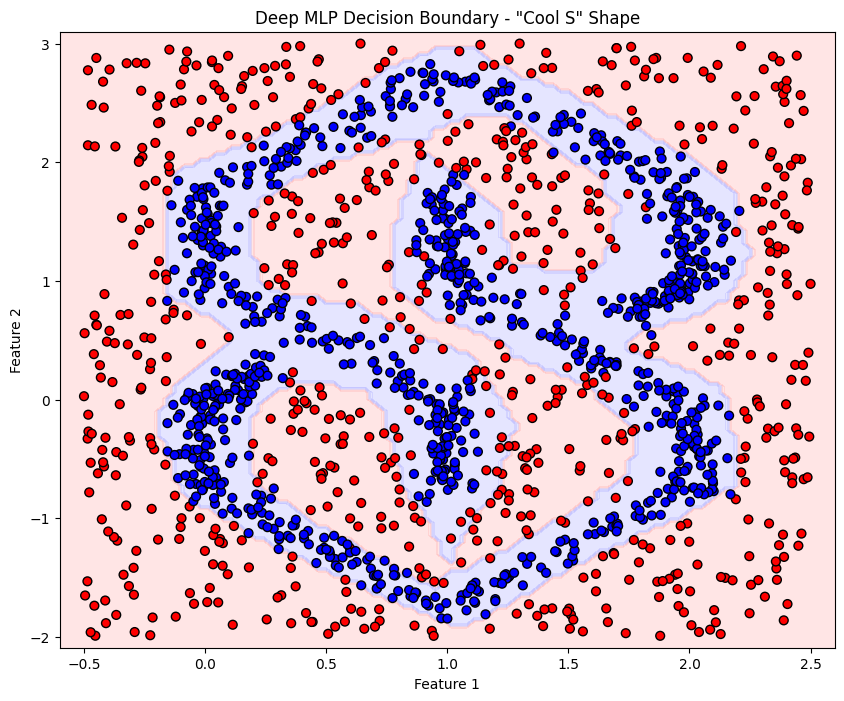

In [13]:
# Define a more complex architecture for the S-shape problem
# Choose appropriate hidden dimensions and layers
input_dim = 2
hidden_dims = [64, 32, 16]  # Three hidden layers with more units
output_dim = 1

# Create and train the model
model_s = DeepMLPClassifier(input_dim, hidden_dims, output_dim)
model_s, _ = train_model(model_s, X_s, y_s, n_epochs=500, learning_rate=0.005)

# Visualize the decision boundary
plot_decision_boundary(model_s, X_s, y_s, 'Deep MLP Decision Boundary - "Cool S" Shape')

Great! Now you should be able to see that a deeper network can learn the complex "cool S" shape. The main takeaway here is that deeper networks can learn more complex patterns than shallower networks.

Note however that there is no 'correct' number of layers or units for a network. The number of layers and units is a hyperparameter that you can tune for your specific task, and this choice will impact the performance and speed of your model. Take some time to expeirment with different numbers of layers and units to see how they affect the performance of your above model!

## V. Scaling MLPs to the Real World

So far, we've worked with synthetic 2D datasets to understand the building blocks of neural networks. But how do these concepts scale to real-world problems with high-dimensional data?

The power of neural networks comes from combining non-linearities with depth, allowing them to learn patterns that scale to the complexity of actual, real-world data (and not just the fairly simple and contrived synthetic examples we've seen so far). Let's demonstrate this by tackling a classic machine learning problem: handwritten digit recognition using the MNIST dataset.

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.65MB/s]


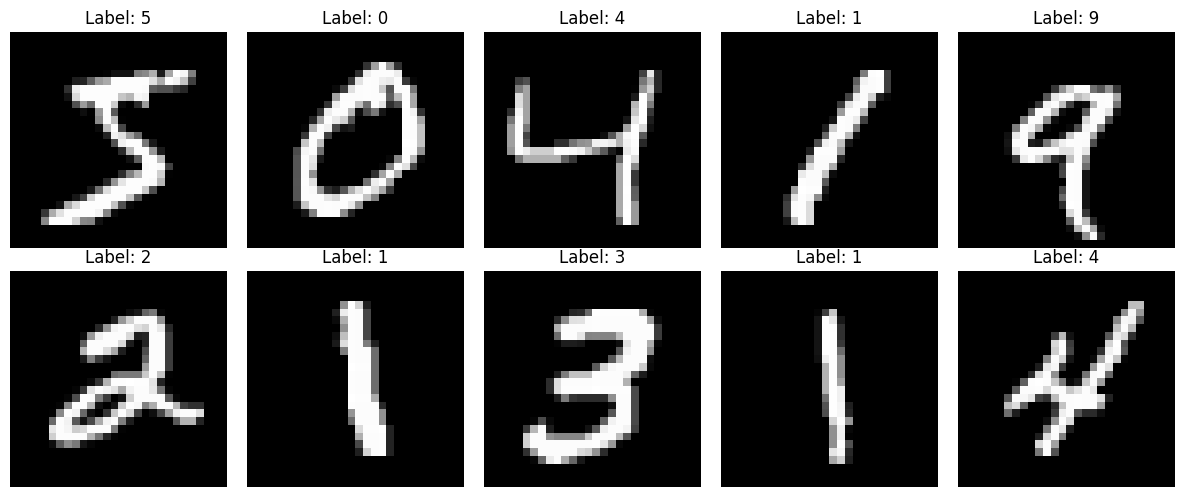

MNIST dataset: 60000 training and 10000 test images
Image shape: torch.Size([28, 28])
Number of classes: 10


In [14]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization values
])

# Download and load the training data
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Display some sample images
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(mnist_train.data[i], cmap='gray')
    plt.title(f"Label: {mnist_train.targets[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"MNIST dataset: {len(mnist_train)} training and {len(mnist_test)} test images")
print(f"Image shape: {mnist_train.data[0].shape}")
print(f"Number of classes: {len(mnist_train.classes)}")

The MNIST dataset is a classic dataset in machine learning, consisting of 60,000 training images and 10,000 test images of handwritten digits. Each image is 28x28 pixels, and the goal is to classify each image into one of 10 classes (0-9).

This dataset is a good testbed for understanding how neural networks can be used to solve real-world problems. With 784 input features (28x28 pixels), it really quite complex and high-dimensional, motivating the entire notion that it is easier to solvereal-world classification problems with neural networks that we can *optimize on training data* rather than with any other manual approach (imagine trying to formulate the specific set of pixel-level rules that would let you do this task more transparently).

Now let's try and solve this problem with a simple MLP! First, let's use what we've learned so far today to build an 'MNISTClassifier' class that can be used to classify MNIST digits. The model will again take in a hidden_dims argument, which is a list of hidden dimensions, but note that the input and output dimensions now differ from before: where the input dimension in the synthetic datasets was just a list of 2D coordinates (a tensor of shape [num_samples, 2]), the input dimension for MNIST is a 28x28 image (a tensor of shape [num_samples, 1, 28, 28]). So you'll need to process the input image a little differently to make sure it can be used as input to the network.


In [15]:
class MNISTClassifier(nn.Module):
    """
    MLP architecture for MNIST digit classification
    """
    def __init__(self, input_size=784, hidden_dims=[128, 64], num_classes=10):
        super(MNISTClassifier, self).__init__()

        # ---- YOUR CODE HERE ----
        # Flatten the 28x28 images to 784-dimensional vectors
        self.flatten = nn.Flatten()

        # Build the layers dynamically based on the hidden_sizes parameter
        layers = []

        # Input layer
        layers.append(nn.Linear(input_size, hidden_dims[0]))
        layers.append(nn.ReLU())

        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))

        # Combine all layers
        self.layers = nn.Sequential(*layers)
        # ----------------------

    def forward(self, x):
        # ---- YOUR CODE HERE ----
        # Input x has shape [batch_size, 1, 28, 28]
        x = self.flatten(x)  # Flatten to [batch_size, 784]
        x = self.layers(x)   # Pass through the layers
        return x
        # ----------------------

#### A note on Stochastic Gradient Descent (SGD) and Minibatching

Now that we've implemented our MNISTClassifier, we can train it on the MNIST dataset. But before we do this, we're going to first update our training function as well. Until now, we have simply used the entire training set to calculate each gradient update when training our models. This is great when the training dataset is small, but it is not practical as we scale up to larger and larger datasets. Imagine trying to calculate a gradient update for a large neural network over millions of high resolution images or trillions of word tokens all at once -- not possible on even the largest supercomputers!

So even though MNIST is actually still a toy dataset where we technically *could* just use the entire training set to calculate each gradient update, we're going to update our training function to use minibatch gradient descent. Minibatch gradient descent is a technique where we use small random subsets of the data to calculate each gradient update rather than the entire dataset. This allows us to continue using the entire dataset to optimize our model, but just not all at once. This means that we can not only scale up to larger datasets more efficiently, but also take advantage of GPU parallelization (since we can process multiple minibatches in parallel on different GPUs) and sometimes also escape local minima more easily (since the noise introduced by minibatching can be useful for escaping local minima).

Minibatch gradient descent introduces a new hyperparameter: the batch size, which is the number of examples in each minibatch. This is a hyperparameter that you can tune for your specific task, and this choice will impact the performance and speed of your model. When batch size is equal to the size of the dataset, then we are just doing batch gradient descent (ie. what we've been doing so far). When batch size is equal to 1, then we are doing *stochastic gradient descent*. When batch size is somewhere in between, then we are doing minibatch gradient descent. Smaller batch sizes are more computationally efficient, but larger batch sizes often lead to better performance because they are more representative of the entire dataset.



In [16]:
def train_mnist_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    """
    Train a model on MNIST with minibatch gradient descent
    """

    # ---- YOUR CODE HERE ----
    # Use categorical cross-entropy loss (requires logits, not probabilities)
    criterion = nn.CrossEntropyLoss()

    # Adam optimizer typically works better than plain SGD for deep networks
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # ----------------------

    # Track metrics
    train_losses = []
    test_accuracies = []

    # Training loop
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Process minibatches
        for batch_idx, (data, target) in enumerate(train_loader): # NEW: note how train_loader is a DataLoader object that returns batches of data and targets

            # ---- YOUR CODE HERE ----
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = criterion(output, target)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()
            # ----------------------

            # Print progress
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Evaluate on test set
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs} complete | Avg Loss: {epoch_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds")

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

    return model, train_losses, test_accuracies

def evaluate_model(model, data_loader):
    """
    Evaluate model accuracy on a dataset
    """
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for evaluation
        for data, target in data_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy

Epoch 1/5 | Batch 0/938 | Loss: 2.3143
Epoch 1/5 | Batch 100/938 | Loss: 0.3272
Epoch 1/5 | Batch 200/938 | Loss: 0.2792
Epoch 1/5 | Batch 300/938 | Loss: 0.2307
Epoch 1/5 | Batch 400/938 | Loss: 0.3832
Epoch 1/5 | Batch 500/938 | Loss: 0.0866
Epoch 1/5 | Batch 600/938 | Loss: 0.0957
Epoch 1/5 | Batch 700/938 | Loss: 0.0499
Epoch 1/5 | Batch 800/938 | Loss: 0.2167
Epoch 1/5 | Batch 900/938 | Loss: 0.1895
Epoch 1/5 complete | Avg Loss: 0.2698 | Test Accuracy: 96.00%
Epoch 2/5 | Batch 0/938 | Loss: 0.2132
Epoch 2/5 | Batch 100/938 | Loss: 0.0228
Epoch 2/5 | Batch 200/938 | Loss: 0.1438
Epoch 2/5 | Batch 300/938 | Loss: 0.0528
Epoch 2/5 | Batch 400/938 | Loss: 0.0817
Epoch 2/5 | Batch 500/938 | Loss: 0.1764
Epoch 2/5 | Batch 600/938 | Loss: 0.1732
Epoch 2/5 | Batch 700/938 | Loss: 0.1934
Epoch 2/5 | Batch 800/938 | Loss: 0.0314
Epoch 2/5 | Batch 900/938 | Loss: 0.1827
Epoch 2/5 complete | Avg Loss: 0.1107 | Test Accuracy: 96.80%
Epoch 3/5 | Batch 0/938 | Loss: 0.0396
Epoch 3/5 | Batch 100

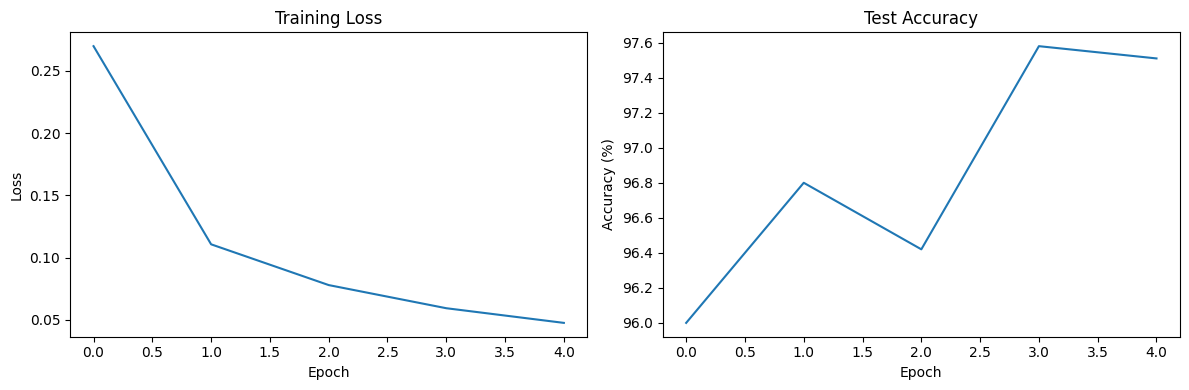

In [17]:

# ---- YOUR CODE HERE ----
# Play with different batch sizes to see how they affect the performance of the model!
batch_size = 64
# ----------------------

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Initialize the MLP model
mnist_mlp = MNISTClassifier(
    input_size=28*28,          # Flattened 28x28 images
    # ---- YOUR CODE HERE ----
    # Play with different hidden dimensions to see how they affect the performance of the model!
    hidden_dims=[128, 64],
    # ----------------------
    num_classes=10             # 10 digit classes
)

# Train the model
trained_model, losses, accuracies = train_mnist_model(
    mnist_mlp,
    train_loader,
    test_loader,
    epochs=5,
    lr=0.001
)

### Visualizing MNIST Predictions

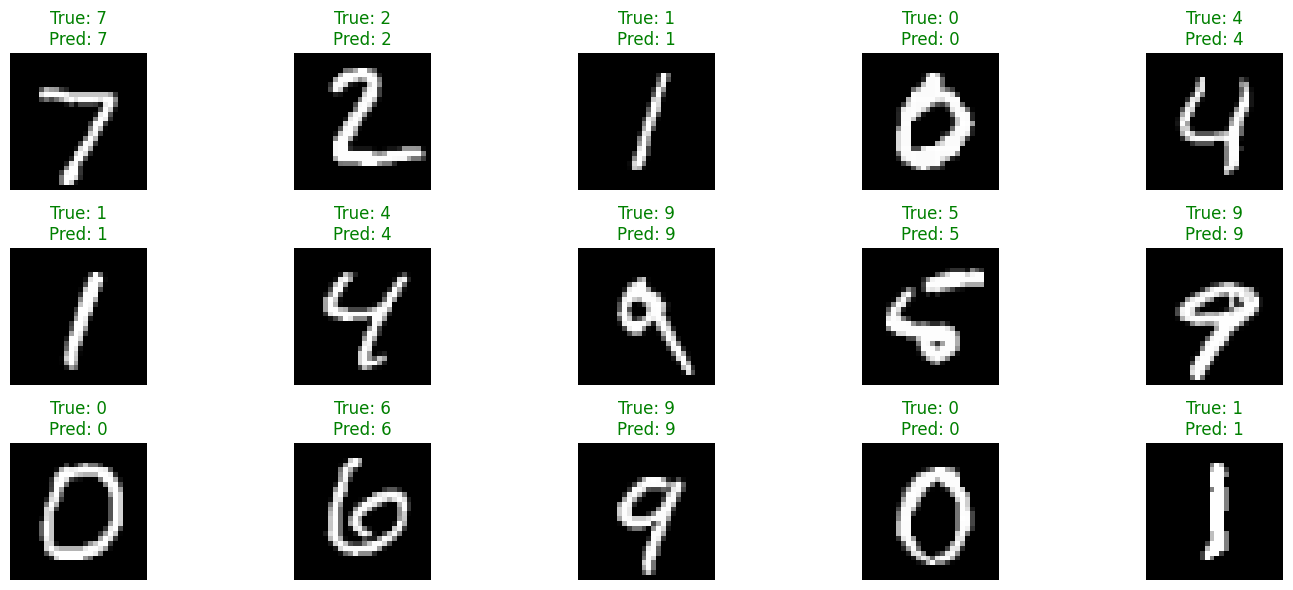

Final test accuracy: 97.51%


In [18]:
def visualize_mnist_predictions(model, test_loader, num_samples=15):
    """
    Visualize model predictions on MNIST test data
    """
    model.eval()

    # Get a batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    # Plot images with their true and predicted labels
    fig = plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(3, 5, i+1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        color = 'green' if predictions[i] == labels[i] else 'red'
        plt.title(f"True: {labels[i]}\nPred: {predictions[i]}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_mnist_predictions(trained_model, test_loader)

# Calculate final accuracy on full test set
final_accuracy = evaluate_model(trained_model, test_loader)
print(f"Final test accuracy: {final_accuracy:.2f}%")

Nice! You should be able to find that even a fairly simple MLP can achieve high accuracy on the MNIST dataset. There's something really special and cool about this -- again, compare the relative ease of training an MLP on MNIST to what it would take to write some kind of pixel-level rule-based classifier (eg. imagine how many 'if-else' statements you'd have to write) to do this task!